In [1]:
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

import cv2
import tensorflow as tf
import io



In [2]:
import yolo3_one_file_to_detect_them_all as yl3

In [3]:
model=yl3.make_yolov3_model()

In [4]:
path="./Yolo data/"
filename="yolov3.weights"

In [5]:
weightReader=yl3.WeightReader(filename)

In [6]:
weightReader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [7]:
modelName="ObjectDetectionYolov3.h5"
model.save(modelName)

C:\Users\Ashwin\miniconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [8]:
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height


In [9]:
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores


In [10]:
def draw_boxes(filename, v_boxes, v_labels, v_scores, text_color='red', box_color='red'):
	# load the image
	data = pyplot.imread(path+filename)
  # plot the image
	fig, ax = pyplot.subplots()
	ax.imshow(data)

	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color=box_color)
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		ax.text(x1, y1, label, color=text_color)

  # show the plot
	fig.savefig(path+'Pred '+filename)


In [11]:
model=load_model(modelName)

In [12]:
def predictForImage(imgName, text_color='yellow', box_color='red'):
    image = img_to_array(
        load_img(path+imgName, target_size=(416, 416))).astype('float32') / 255.0

    # define the expected input shape for the model
    input_w, input_h = 416, 416
    # define our new photo
    photo_filename = path+imgName
    # load and prepare image
    image, image_w, image_h = load_image_pixels(
        photo_filename, (input_w, input_h))

    # make prediction
    yhat = model.predict(image)

    # define the anchors
    anchors = [[116, 90, 156, 198, 373, 326], [
        30, 61, 62, 45, 59, 119], [10, 13, 16, 30, 33, 23]]
    # define the probability threshold for detected objects
    class_threshold = 0.2
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += yl3.decode_netout(netout=yhat[i][0], anchors=anchors[i], obj_thresh=class_threshold, net_h=input_h, net_w=input_w)

    # correct the sizes of the bounding boxes for the shape of the image
    yl3.correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

    # suppress non-maximal boxes
    yl3.do_nms(boxes, 0.01)

    # define the labels
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
              "bird", "dog", "horse", "sheep", "cow", "elephant", "bear", "giraffe", "raccoon", "zebra",
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
              "chair", "sofa", "pottedplant", "bed", "diningtable", "pen", "tvmonitor", "laptop", "mouse",
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

    # draw what we found
    draw_boxes(imgName, v_boxes, v_labels, v_scores, text_color, box_color)


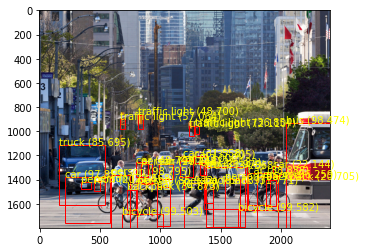

In [13]:
predictForImage('street.jpg')

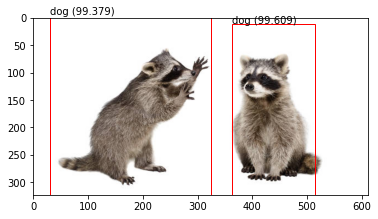

In [14]:
predictForImage('raccoon.jpg', text_color='black')


In [15]:
def getVideoAsFrames(vidName, vidForm):
    cap = cv2.VideoCapture(path+vidName+vidForm)
    cap
    video = []
    frameNo = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        fname = vidName+' '+str(len(video)+1)+'.jpg'
        if frameNo % 10 == 0:
            cv2.imwrite(path+fname, frame)
            video.append(fname)
        frameNo += 1
    cap.release()
    return video

In [16]:
video = getVideoAsFrames('Home video', '.mp4')

In [17]:
len(video)

45

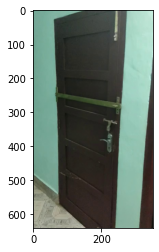

In [18]:
predictForImage(video[0])

C:\Users\Ashwin\AppData\Local\Temp/ipykernel_9212/3518093533.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = pyplot.subplots()


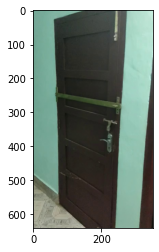

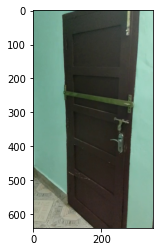

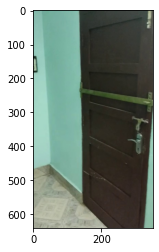

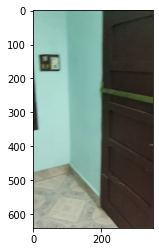

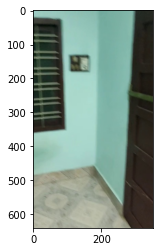

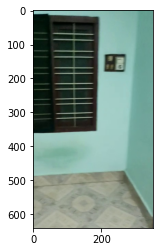

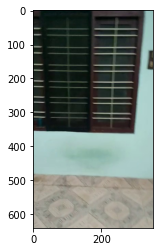

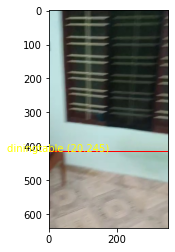

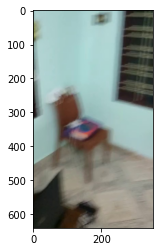

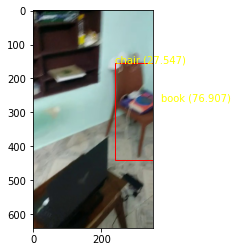

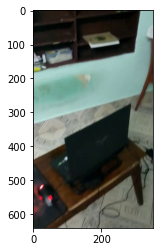

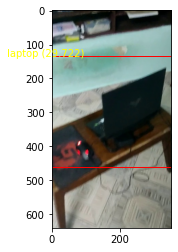

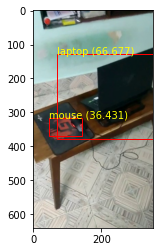

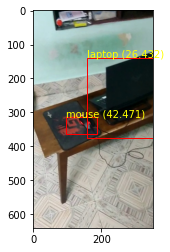

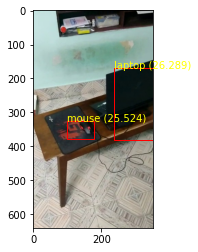

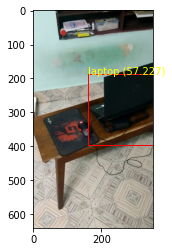

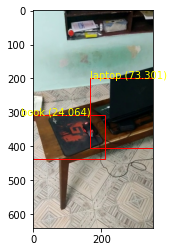

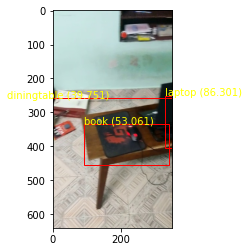

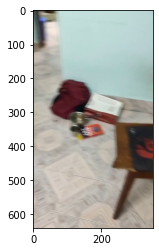

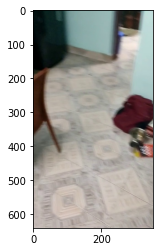

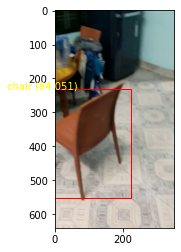

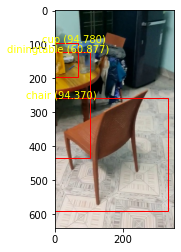

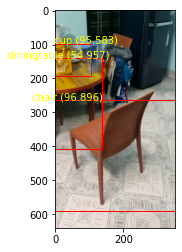

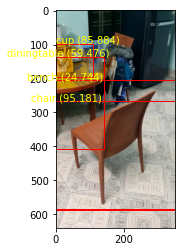

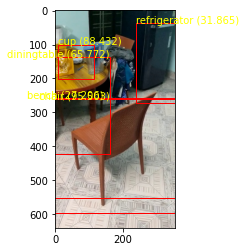

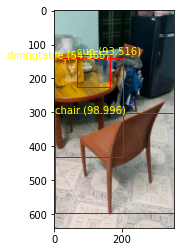

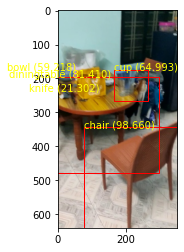

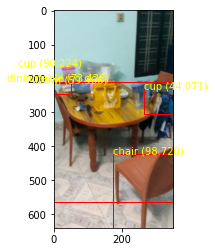

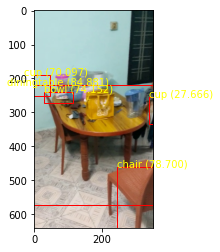

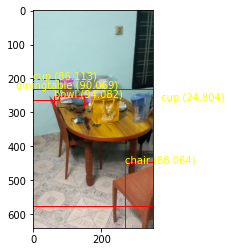

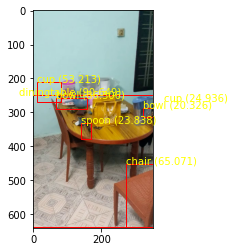

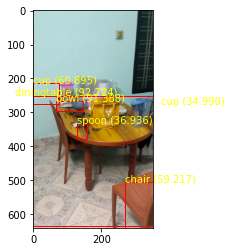

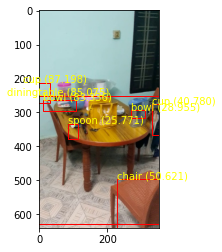

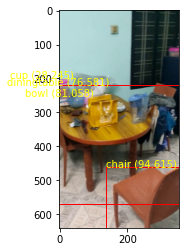

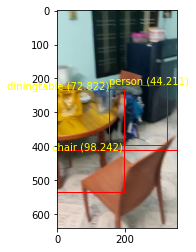

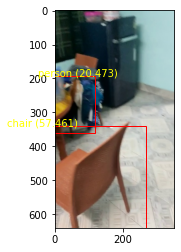

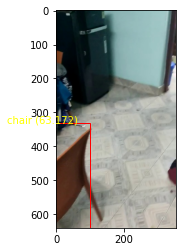

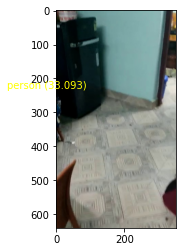

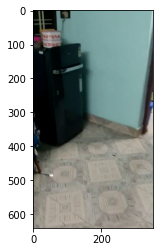

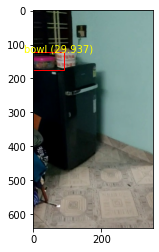

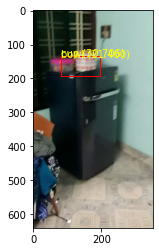

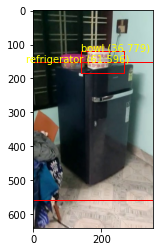

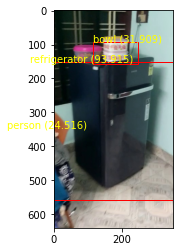

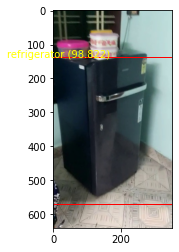

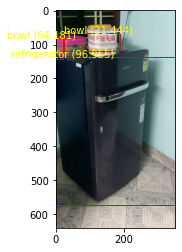

In [19]:
for frame in video:
    predictForImage(frame)